# Plot Global Irradiance on tilted surface (using test reference year (TRY) data)

### Prerequesits:

In order to run this notebook you need to have test reference year data from the Deutsche Wetterdienst downloaded.

### Content:

* [User input](#user_input)
* [Read weather data](#weather_data)
* [Plot global irradiance](#plot_global_irradiance)


## User input <a class="anchor" id="user_input"></a>

In [1]:
# filename of test reference year data csv file
weather_data_filename = 'try.dat'

### Input for plotting

In [2]:
# latitude and longitude of the location plot is created for
# (necessary for solar position calculations)
latitude_plot = 52.47
longitude_plot = 13.30

In [3]:
#import pytz
#print(pytz.all_timezones)

The following variables can be left as they are and only need to be changed if fine tuning of the plot is needed.

*azimuths_number_of_points* and *tilts_number_of_points* set the number of combinations of azimuths and tilts the sum of the global irradiance is calculated for. The higher the number the longer the calculation time but the higher the resolution of the plot.

In [4]:
azimuths_number_of_points = 120  # should be at least 70
tilts_number_of_points = 30  # should be at least 18

Through the following parameters you may change the fontsizes used in the plot, etc.

In [5]:
# font sizes
axes_label_fontsize = 16
contour_label_fontsize = 16
unit_label_fontsize = 16

# figure size (width x height)
figsize = (14, 8)

# dpi of figure
dpi = 1200

# format to save plot as (e.g. 'pdf')
plot_file_format= 'pdf'

# colormaps used in plots
# for an overview of possible colormaps see here: 
# https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
colormap_year = 'RdYlGn_r'
colormap_summer = 'YlGn_r'
colormap_winter = 'winter'

# define summer and winter months
summer_months = [5, 6, 7, 8, 9, 10]
winter_months = [1, 2, 3, 4, 11, 12]

## Read TRY weather data <a class="anchor" id="weather_data"></a>

In [6]:
import pandas as pd
import datetime

# read TRY data
weather_df = pd.read_csv(weather_data_filename, header=[27], sep='\s+')
weather_df.drop(index=[0], inplace=True)

# pvlib needs a time index wherefore it is here generated for a random year
weather_df['date_time'] = weather_df.apply(
    lambda _: datetime.datetime.strptime('2019-{}-{} {}'.format(
        int(_.MM), int(_.DD), int(_.HH)-1), '%Y-%m-%d %H'), axis=1)

# calculate GHI
weather_df['ghi'] = weather_df['B'] + weather_df['D']

# rename 'D' to 'DHI'
weather_df.rename(columns={'D': 'dhi'}, inplace=True)

# select only needed columns
weather_df = weather_df.loc[:, ['date_time', 'dhi', 'ghi']]

# set date time index and time zone
# (see explanation on Wikipedia why correct time zone is GMT-1 instead of GMT+1)
# Wikipedia link: https://en.wikipedia.org/wiki/Tz_database#Area
weather_df.set_index('date_time', inplace=True)
weather_df.index = weather_df.index.tz_localize('Etc/GMT-1')

## Plot global irradiance on tilted surface <a class="anchor" id="plot_global_irradiance"></a>

In [7]:
import numpy as np
import pandas as pd
from pvlib.modelchain import ModelChain
from pvlib.pvsystem import PVSystem
from pvlib.location import Location
from feedinlib.models import get_power_plant_data
from functools import partial

In [8]:
# calculate sum of global horizontal irradiance on tilted surface in kWh/(m²a) for 
# azimuths from -180° to 180° and tilt angles from 0° to 90°

azimuths = np.linspace(0.0, 360.0, azimuths_number_of_points)
tilts = np.linspace(0.0, 90.0, tilts_number_of_points)
sum_global_irr_tilted_surface_year = np.zeros(
    (tilts_number_of_points, azimuths_number_of_points))
sum_global_irr_tilted_surface_summer = np.zeros(
    (tilts_number_of_points, azimuths_number_of_points))
sum_global_irr_tilted_surface_winter = np.zeros(
    (tilts_number_of_points, azimuths_number_of_points))

location = Location(
    latitude=latitude_plot,
    longitude=longitude_plot,
    tz=weather_df.index.tz)

# dummy PV system parameters for pvlib ModelChain
module_name = 'Advent_Solar_Ventura_210___2008_'  # module name as in database
inverter_name = 'ABB__MICRO_0_25_I_OUTD_US_208__208V_'  # inverter name as in database
pv_system_data = {
    'module_parameters': get_power_plant_data("SandiaMod")[module_name],
    'inverter_parameters': get_power_plant_data("CECInverter")[inverter_name],  
    'albedo': 0.2,
    'surface_tilt': 0,
    'surface_azimuth': 0}

pv_system = PVSystem(**pv_system_data)
    
mc = ModelChain(pv_system, location)
mc.complete_irradiance(weather=weather_df)

solar_position = location.get_solarposition(
    weather_df.index, method=mc.solar_position_method)
airmass = location.get_airmass(
    solar_position=solar_position, model=mc.airmass_model)
        
for i in range(len(tilts)):
    pv_system_data['surface_tilt'] = tilts[i]
    for j in range(len(azimuths)):
        pv_system_data['surface_azimuth'] = azimuths[j]
        pv_system = PVSystem(**pv_system_data)
        #mc.system = pv_system
        
        aoi = pv_system.get_aoi(
                solar_position['apparent_zenith'],
                solar_position['azimuth'])
        get_irradiance = partial(
                pv_system.get_irradiance,
                solar_position['apparent_zenith'],
                solar_position['azimuth'])

        total_irrad = get_irradiance(
            mc.weather['dni'],
            mc.weather['ghi'],
            mc.weather['dhi'],
            airmass=airmass['airmass_relative'],
            model=mc.transposition_model)

        poa_global = total_irrad.poa_global
        sum_global_irr_tilted_surface_summer[i, j] = poa_global.loc[
            poa_global.index.month.isin(summer_months)].sum() / 1e3
        sum_global_irr_tilted_surface_winter[i, j] = poa_global.loc[
            poa_global.index.month.isin(winter_months)].sum() / 1e3
        sum_global_irr_tilted_surface_year[i, j] = poa_global.sum() / 1e3

In [9]:
# save sums of global irradiance
year = 'try'
filename = 'sum_global_irr_tilted_surface_{season}_lat_{lat}_lon_{lon}_year_{year}.csv'
pd.DataFrame(sum_global_irr_tilted_surface_summer).to_csv(filename.format(
    lat=latitude_plot, lon=longitude_plot, year=year, season='summer'))
pd.DataFrame(sum_global_irr_tilted_surface_winter).to_csv(filename.format(
    lat=latitude_plot, lon=longitude_plot, year=year, season='winter'))
pd.DataFrame(sum_global_irr_tilted_surface_year).to_csv(filename.format(
    lat=latitude_plot, lon=longitude_plot, year=year, season='year'))

In order to recover previously calculated sums of global irradiance, execute the following code:

```python
filename = 'sum_global_irr_tilted_surface_{season}_lat_{lat}_lon_{lon}_year_{year}.csv'
sum_global_irr_tilted_surface_summer = pd.read_csv(
    filename.format(lat=latitude_plot, lon=longitude_plot, year=year, season='summer'),
    index_col=[0]).values
sum_global_irr_tilted_surface_winter = pd.read_csv(
    filename.format(lat=latitude_plot, lon=longitude_plot, year=year, season='winter'),
    index_col=[0]).values
sum_global_irr_tilted_surface_year = pd.read_csv(
    filename.format(lat=latitude_plot, lon=longitude_plot, year=year, season='year'),
    index_col=[0]).values
```

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib

def create_plot(data, colormap, plot_filename, unit_label_text):
    """
    Function to plot sums of global horizontal irradiance.
    
    Parameters
    -----------
    data : np.array
        Data to plot
    colormap : str
        Specifies colormap used in plot, e.g. "winter".
    plot_filename : str
        Filename to save plot under, e.g. "test_plot.png".
    unit_label_text : str
        Unit of data plotted, e.g. "kWh/(m$^2 \cdot$ Sommerhalbjahr)".
        
    """
    
    # set label font size
    font = {'size': axes_label_fontsize}
    matplotlib.rc('font', **font)

    plt.figure(figsize=figsize)

    azimuths = np.linspace(-180.0, 180.0, azimuths_number_of_points)
    tilts = np.linspace(0.0, 90.0, tilts_number_of_points)
    X, Y = np.meshgrid(azimuths, tilts)

    # plot contour lines at specified levels with labels
    min_contour_line = int(np.floor(data.min() / 100.0)) * 100
    max_contour_line = int(np.floor(data.max() / 100.0)) * 100
    levels = list(np.arange(min_contour_line, max_contour_line+1, 50.)) + \
        [np.ceil(data.max())]
    contour = plt.contour(X, Y, data, levels, colors='k')
    level_labels = [_ for _ in levels if _%200==0]
    plt.clabel(contour, colors='k', fmt='%4.0f', fontsize=contour_label_fontsize, levels=level_labels)

    # plot filled contour with colors specified by colormap
    cmap = cm.get_cmap(colormap)
    contour_filled = plt.contourf(X, Y, data, levels, cmap=cmap)

    # add max value label
    ind_max_value = np.unravel_index(
        np.argmax(
            data, axis=None),
        data.shape)
    plt.scatter(azimuths[ind_max_value[1]], tilts[ind_max_value[0]],
                marker='o', facecolors='none', edgecolors='k', s=80)
    plt.text(azimuths[ind_max_value[1]]+3, tilts[ind_max_value[0]],
             str(int(np.ceil(data.max()))),
             fontsize=unit_label_fontsize, 
             horizontalalignment='left', 
             verticalalignment='top')

    # add axes and tick labels
    plt.xlabel('Azimuthwinkel in °', horizontalalignment='right', x=1.0)
    plt.ylabel('Neigungswinkel in °')
    axes = plt.gca()
    axes.set_xticks(np.arange(-180, 190, 30))
    axes.set_yticks(np.arange(0, 100, 10))

    # add cardinal direction at top of plot
    ax2 = axes.twiny()
    ax2.set_xlim(axes.get_xlim())
    ax2.set_xticks([-180, -90, 0, 90, 180])
    ax2.set_xticklabels(['Nord', 'Ost', 'Süd', 'West', 'Nord'])

    # unit label
    plt.text(0.99, 0.0, unit_label_text,
             fontsize=unit_label_fontsize, 
             horizontalalignment='right', 
             verticalalignment='bottom', 
             transform = axes.transAxes)

    plt.savefig(plot_filename, dpi=dpi)

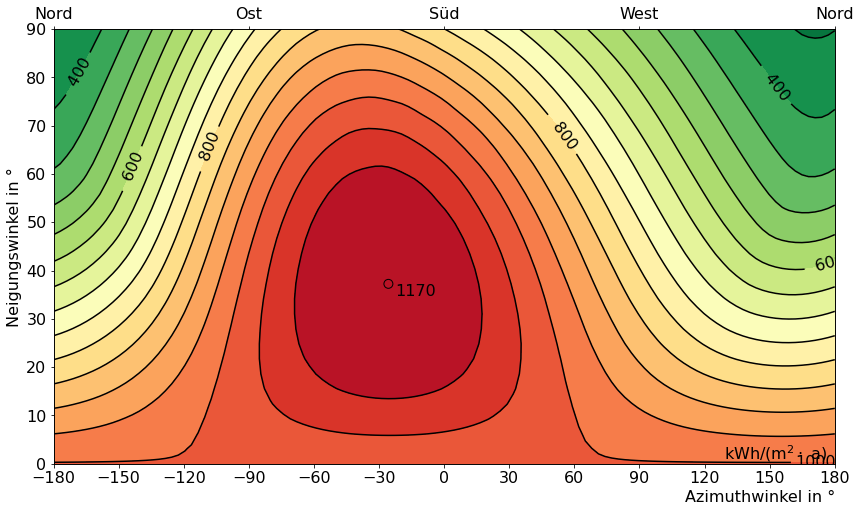

In [11]:
# plot year
plot_filename = 'Jahressumme_Globalstrahlung_lat_{}_lon_{}_Jahr_{}.{}'.format(
    latitude_plot, longitude_plot, year, plot_file_format)
create_plot(sum_global_irr_tilted_surface_year,
            colormap_year,
            plot_filename,
            'kWh/(m$^2 \cdot$ a)')

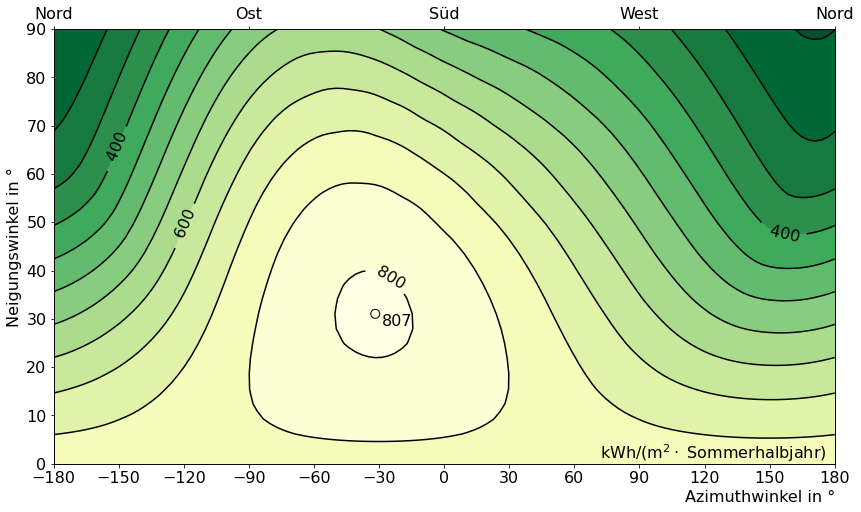

In [12]:
# plot summer
plot_filename = 'Jahressumme_Globalstrahlung_lat_{}_lon_{}_Sommerhalbjahr_{}.{}'.format(
    latitude_plot, longitude_plot, year, plot_file_format)
create_plot(sum_global_irr_tilted_surface_summer,
            colormap_summer,
            plot_filename,
            'kWh/(m$^2 \cdot$ Sommerhalbjahr)')

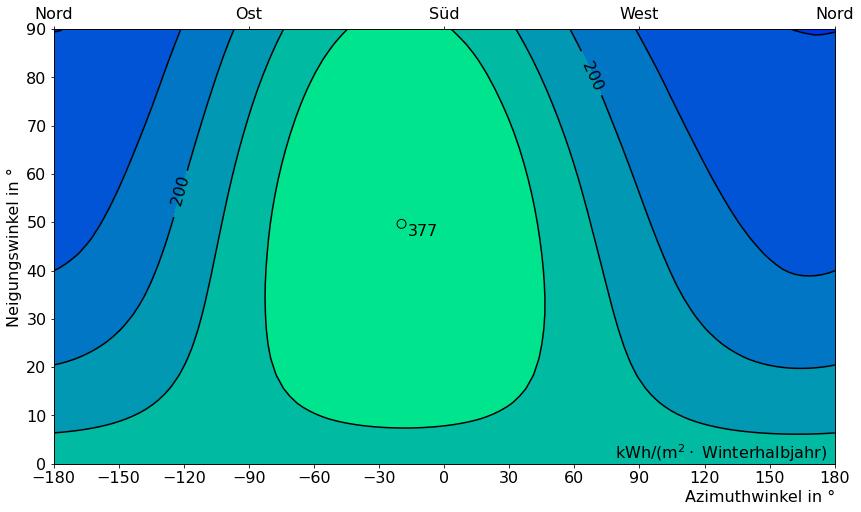

In [13]:
# plot winter
plot_filename = 'Jahressumme_Globalstrahlung_lat_{}_lon_{}_Winterhalbjahr_{}.{}'.format(
    latitude_plot, longitude_plot, year, plot_file_format)
create_plot(sum_global_irr_tilted_surface_winter,
            colormap_winter,
            plot_filename,
            'kWh/(m$^2 \cdot$ Winterhalbjahr)')